# Logistic 回归——Rental Listing Inquiries 数据集

Kaggle 平台上的一个分类竞赛任务，需要根据公寓的特征来预测其受欢迎程度（用户感兴趣程度分为高、中、低三类）。

Logistic 回归有：缺省参数 LogisticRegression、LogisticRegression + GridSearchCV 以及 LogisticRegressionCV

实际应用中，任选一个即可。

### 由于作业没有要求使用多种Logistic 回归方式，且时间太紧张，
### 所以这里选择 LogisticRegressionCV 进行模型训练，参数调优。

评价标准为 logloss

In [1]:
# 首先 import 必要的包包
import pandas as pd 
import numpy as np

from sklearn.metrics import log_loss  

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索
数据用特征工程之后的。已经进行了标准化。

In [2]:
dpath = './data/'
# 训练数据
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
train.head()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,top_10_manager,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,0.574016,1.307938,-0.042355,0.011220,-0.037621,-0.045241,-0.116088,-1.235108,1.207530,1,...,0,0,0,0,0,0,0,0,0,1
1,-0.423163,0.411083,0.083246,-0.009325,0.074086,0.094018,0.020990,-0.707528,0.170240,1,...,0,0,0,0,0,0,0,0,0,2
2,-0.423163,-0.485772,-0.004299,-0.039124,-0.044419,-0.024795,-0.029748,0.347633,-0.521286,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.423163,-0.485772,0.019349,-0.010174,-0.025159,-0.005485,-0.002567,0.347633,-0.521286,1,...,0,0,0,0,0,0,0,0,0,2
4,-0.423163,2.204793,0.129290,0.005447,-0.021760,-0.002078,-0.126321,-2.817850,1.553293,0,...,0,0,1,0,0,0,0,0,0,2


In [3]:
# 测试数据
test = pd.read_csv(dpath +"RentListingInquries_FE_test.csv")
test.head()

,listing_id,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,7142618,-0.423163,-0.485772,-0.036090,-0.026135,-0.039887,-0.020252,-0.023352,0.347633,-0.521286,...,0,0,0,0,0,0,0,0,0,0
1,7210040,-0.423163,0.411083,-0.021526,-0.037596,-0.044419,-0.024795,-0.090506,-0.707528,0.170240,...,0,0,0,1,0,0,0,0,0,0
2,7103890,-0.423163,-0.485772,-0.017141,-0.028257,-0.003271,0.016460,0.028324,0.347633,-0.521286,...,0,0,0,0,0,0,0,0,0,0
3,7143442,-0.423163,0.411083,-0.047993,-0.001175,-0.024026,-0.004349,-0.071319,-0.707528,0.170240,...,0,0,0,0,0,0,1,0,0,0
4,6860601,1.571195,0.411083,0.036733,-0.024437,0.048482,-0.005864,-0.003100,0.347633,0.861767,...,0,0,0,1,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 219 entries, bathrooms to interest_level
dtypes: float64(9), int64(210)
memory usage: 82.5 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Columns: 219 entries, listing_id to work
dtypes: float64(9), int64(210)
memory usage: 124.7 MB


In [6]:
# 各属性的统计特性
train.describe()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,top_10_manager,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
count,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,4.935200e+04,49352.000000,...,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000
mean,2.964299e-17,2.648709e-15,-3.630831e-15,2.854481e-15,5.933519e-17,-1.307700e-16,-3.395913e-17,4.457247e-16,-1.357776e-15,0.605751,...,0.003080,0.000385,0.186477,0.009361,0.000446,0.028165,0.002026,0.001013,0.000952,1.616895
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.488694,...,0.055412,0.019618,0.389495,0.101625,0.021109,0.165446,0.044969,0.031814,0.030846,0.626035
min,-2.417520e+00,-1.382628e+00,-6.380533e+01,-3.762228e+01,-1.716244e-01,-1.523321e-01,-2.065213e-01,-4.928172e+00,-1.904339e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.231625e-01,-4.857723e-01,-2.074272e-02,-3.054969e-02,-6.027986e-02,-4.296934e-02,-7.558277e-02,-7.075278e-01,-5.212861e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-4.231625e-01,-4.857723e-01,1.606063e-02,-1.883392e-02,-3.082363e-02,-1.797992e-02,-3.506687e-02,3.476331e-01,-5.212861e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,-4.231625e-01,4.110829e-01,5.129788e-02,7.772486e-04,1.222778e-02,1.382480e-02,3.900444e-02,3.476331e-01,8.617668e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.752606e+01,5.792214e+00,6.486716e+00,6.278607e+01,2.033010e+02,2.038502e+02,1.912286e+02,8.788921e+00,7.431268e+00,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [7]:
# 各属性的统计特性
test.describe()

,listing_id,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
count,7.465900e+04,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,...,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000,74659.000000
mean,7.024001e+06,0.001466,0.002712,-0.010156,0.008858,-0.003677,-0.003571,-0.003356,-0.002415,0.002599,...,0.001058,0.003094,0.000442,0.188243,0.008653,0.000388,0.027994,0.002156,0.001085,0.000884
std,1.264496e+05,1.295973,0.992831,1.263352,1.263091,0.440171,0.433629,0.573325,1.082757,1.035559,...,0.032922,0.055539,0.021020,0.390908,0.097548,0.019705,0.164957,0.046388,0.032921,0.029720
min,6.811958e+06,-2.417520,-1.382628,-63.805329,-40.353413,-0.173528,-0.154240,-0.211979,-5.983333,-1.904339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.915516e+06,-0.423163,-0.485772,-0.021526,-0.030635,-0.060506,-0.043424,-0.075796,-0.707528,-0.521286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.021738e+06,-0.423163,-0.485772,0.015747,-0.018664,-0.030824,-0.017980,-0.035824,0.347633,-0.521286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.129166e+06,-0.423163,0.411083,0.051298,0.000862,0.012228,0.013825,0.037406,0.347633,0.861767,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.761779e+06,220.950557,4.895359,3.337602,62.786074,75.732855,75.949852,71.205126,115.360176,77.621201,...,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


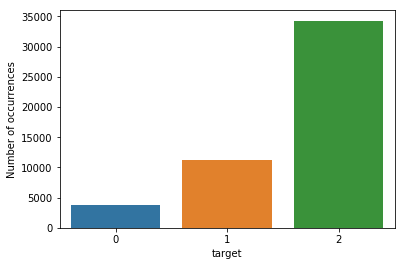

In [8]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.interest_level);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

各类样本不均衡。交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样
## 分离目标值和输入特征

In [9]:
y_train = train['interest_level']
X_train = train.drop(["interest_level"], axis=1)

# listing_id 用于输出预测结果
listing_id_test = test['listing_id']
X_test = test.drop(["listing_id"], axis=1)

# 如果计算资源有限，也可只取少量样本，如取前1000个样本
## 训练样本有 49352 个，我电脑最多能取 20%
## 老师批改作业时，如果计算资源充足，可以试一下全体样本，谢谢！

In [12]:
#将数据分割
from sklearn.model_selection import train_test_split

# 随机采样数据构建测试样本 test_size 是测试样本比例，其余作为训练样本
# 注意，这里的 test 其实是校验集，不是测试数据，
# 下面只用到了部分训练集，所以用后缀 _part
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, random_state=33, test_size=0.8)

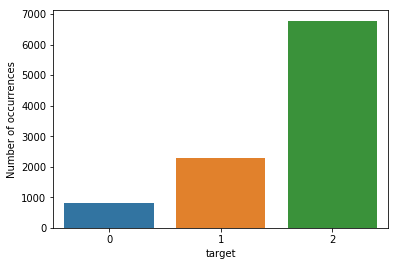

In [16]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(y_train_part);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

In [17]:
# 把 DataFrame 转换为 二维数组，用于模型训练
X_train_part = np.array(X_train_part)

## 模型训练
### 用LogisticRegressionCV实现正则化的 Logistic Regression
### L1正则

In [26]:
from sklearn.linear_model import LogisticRegressionCV

# Cs = [1, 10,100,1000]
# 上面评分递减，所以在右侧扩充参数搜索
# Cs = [1000, 10000, 100000]
# 上面评分递减，所以在右侧扩充参数搜索
Cs = [100000, 1000000, 10000000]

# 大量样本（1W+）、高维度（219），L1正则 --> 可选用 saga 优化求解器(0.19版本新功能)
lrcv_L1 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l1', solver='saga', multi_class='ovr')
lrcv_L1.fit(X_train_part, y_train_part)    

D:\Applications\Anaconda\envs\python3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegressionCV(Cs=[100000, 1000000, 10000000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='saga', tol=0.0001, verbose=0)

In [27]:
lrcv_L1.scores_

{0: array([[-0.28486672, -0.2777516 , -0.27484064],
        [-0.29067013, -0.28396836, -0.28121744],
        [-0.28165056, -0.27464917, -0.27125141],
        [-0.28262071, -0.27589641, -0.2729044 ],
        [-0.28926475, -0.27947143, -0.27469807]]),
 1: array([[-0.52115462, -0.51403091, -0.51054577],
        [-0.52581307, -0.51916873, -0.51623885],
        [-0.52152788, -0.51489861, -0.51161382],
        [-0.52225841, -0.51913301, -0.51792349],
        [-0.52618944, -0.51980067, -0.51671543]]),
 2: array([[-0.57924935, -0.57134853, -0.56752259],
        [-0.58452534, -0.57761068, -0.57401941],
        [-0.57846944, -0.57046346, -0.56627444],
        [-0.5801972 , -0.57618702, -0.57455224],
        [-0.58155117, -0.57374086, -0.56972561]])}

In [30]:
lrcv_L1.Cs

[100000, 1000000, 10000000]

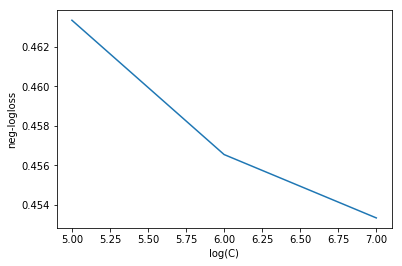

In [28]:
# scores_：dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lrcv_L1.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

In [31]:
lrcv_L1.coef_

array([[ -7.13439564e-02,  -1.75756368e-02,   3.56612016e-02,
          2.15988117e-03,  -2.16827335e-01,  -1.92248135e-01,
         -1.76736157e-01,  -1.70682200e-02,  -3.82897082e-02,
          2.26726006e-02,  -7.33430808e-02,   2.58431877e-02,
         -8.72961955e-01,  -1.80268506e-01,  -2.41231243e-01,
         -6.80125008e-03,  -3.17320709e-02,  -2.43938709e-01,
         -4.02960916e-03,  -3.73935325e-03,  -5.78616724e-03,
          1.19286803e-03,  -6.91319237e-03,   6.32616563e-02,
         -7.56584213e-04,  -1.24225965e-02,  -1.41076933e-01,
         -9.51408373e-03,   1.22181591e-02,   4.55795425e-04,
         -3.81912811e-02,  -1.72876961e-03,  -1.08170836e-02,
          1.10970327e-02,  -6.47138008e-03,  -7.25659551e-03,
         -4.74704335e-03,  -5.47010433e-03,  -7.34120182e-03,
          1.30657199e-02,   1.89673990e-03,  -6.91316930e-03,
         -3.83109933e-03,   2.31141425e-02,  -1.09281230e-02,
          4.34501317e-03,  -9.81973313e-03,  -6.22133565e-03,
        

惩罚不够，没有稀疏系数
### L2正则

In [39]:
# Cs = [1, 10,100,1000]
# 评分是随 C 递增的，所以继续缩小 C 搜索参数
Cs = [0.01, 0.1, 1, 10]

# 大量样本（6W+）、高维度（93），L2正则 --> 缺省用 lbfgs : 
# 这个速度比上面的快多了
lr_cv_L2 = LogisticRegressionCV(Cs=Cs, cv = 5, scoring='neg_log_loss', penalty='l2', solver='lbfgs', multi_class='ovr')
lr_cv_L2.fit(X_train_part, y_train_part)    

D:\Applications\Anaconda\envs\python3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [40]:
lr_cv_L2.scores_

{0: array([[-0.27297495, -0.26999895, -0.2727609 , -0.27129071],
        [-0.27711318, -0.2705787 , -0.26121194, -0.26227541],
        [-0.27041523, -0.26049082, -0.25235522, -0.25609604],
        [-0.26986889, -0.26911056, -0.25314535, -0.25577489],
        [-0.26950624, -0.25912247, -0.24848064, -0.24811187]]),
 1: array([[-0.50830114, -0.49846208, -0.50404163, -0.50852449],
        [-0.51232143, -0.50249293, -0.4979875 , -0.49941611],
        [-0.5099018 , -0.49817083, -0.49255798, -0.49821512],
        [-0.51548538, -0.50528835, -0.49872559, -0.50473111],
        [-0.51061015, -0.49904026, -0.49342152, -0.5004284 ]]),
 2: array([[-0.56931706, -0.54847982, -0.53742106, -0.5410317 ],
        [-0.57423586, -0.54891023, -0.53120893, -0.53215618],
        [-0.56871453, -0.54189536, -0.52453504, -0.52825881],
        [-0.5747666 , -0.55617033, -0.53905881, -0.54627694],
        [-0.56846494, -0.54135211, -0.52421865, -0.53092955]])}

这个评分看上去，比 L1 正则要好，而且评分是随 C 递增的，所以继续缩小 C 搜索参数

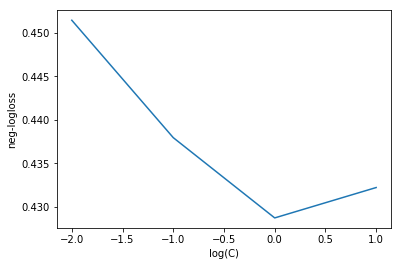

In [41]:
# dict with classes as the keys, and the values as the grid of scores obtained during cross-validating each fold,
# Each dict value has shape (n_folds, len(Cs))
n_Cs = len(Cs)
n_classes = 3
scores =  np.zeros((n_classes,n_Cs))

for j in range(n_classes):
        scores[j][:] = np.mean(lr_cv_L2.scores_[j],axis = 0)
    
mse_mean = -np.mean(scores, axis = 0)
pyplot.plot(np.log10(Cs), mse_mean.reshape(n_Cs,1)) 
#plt.plot(np.log10(reg.Cs)*np.ones(3), [0.28, 0.29, 0.30])
pyplot.xlabel('log(C)')
pyplot.ylabel('neg-logloss')
pyplot.show()

#### 最佳的 log(C) 是 0 ，还可以继续在 0 附近搜索。时间太紧张，先交作业，再继续。
## 使用 lr_cv_L2 预测，输出结果

In [45]:
y_predict = lr_cv_L2.predict(X_test)
result = pd.DataFrame(y_predict, columns=['interest_level'])
result = pd.concat([listing_id_test, result], axis = 1)
result.to_csv(dpath+'RentListingInquries_lr_cv_L2.csv', index=False)

In [46]:
y_predict.shape

(74659,)